# Note: the below method is built based on the original Linear Regression Model, whose coefficients are used directly without explaining or demonstration

# Import Library


In [1]:
%matplotlib inline
import numpy as np
import cv2
from velocity import VeloEval
import copy
import math
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn import preprocessing, datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import math
import os



In [2]:
dataset_path = 'benchmark_velocity_train/clips/'
folder_path = os.listdir(dataset_path)

annotations = [os.path.join(dataset_path, x, 'annotation.json') for x in folder_path]
annotations.remove('benchmark_velocity_train/clips/.DS_Store/annotation.json')
annotations.sort() #sort it so that we can read images in order
gt = VeloEval.load_annotation(annotations)


Finished loading 1074 annotations.


In [3]:
images_training_paths = []
for x in folder_path:
    image_path = "benchmark_velocity_train/clips/"+x+"/imgs/040.jpg"
    images_training_paths.append(image_path)
images_training_paths.remove('benchmark_velocity_train/clips/.DS_Store/imgs/040.jpg')
images_training_paths.sort()
len(images_training_paths)

1074

In [4]:
dataset_path_t = 'benchmark_velocity_test/clips/'
folder_path_t = os.listdir(dataset_path_t)

annotations_t = [os.path.join('.','gt.json')]
#annotations_t.remove('benchmark_velocity_test/clips/.DS_Store/annotation.json')
annotations_t.sort() #sort it so that we can read images in order
gt_t = VeloEval.load_json_file(annotations_t)[0]
len(gt_t)

269

In [5]:
images_testing_paths = []
for x in folder_path_t:
    image_path = "benchmark_velocity_test/clips/"+x+"/imgs/040.jpg"
    images_testing_paths.append(image_path)
images_testing_paths.remove('benchmark_velocity_test/clips/.DS_Store/imgs/040.jpg')
images_testing_paths.sort()
len(images_testing_paths)

269

In [6]:
def get_v(flag, gt):
    
    
    if flag == 0:
        #testing data
        y1 = gt['bbox']['top']
        x2 = gt['bbox']['right']
        x1 = gt['bbox']['left']
        y2 = gt['bbox']['bottom']
        z0 = gt['position'][0]
        x0 = gt['position'][1]
    else:
        #training
        y1 = gt['bbox'][0][0]
        x1 = gt['bbox'][0][1]
        y2 = gt['bbox'][0][2]
        x2 = gt['bbox'][0][3]
        z0 = gt['position'][0]
        x0 = gt['position'][1]
    return (x1,x2,y1,y2,z0,x0)

In [7]:
def get_car_width_2(gt,flag=1):
    '''Input is ground truth of an image that includes the position and bbox of cars.
    There could be more than one cars. Divide these cars into 3 different classes based on their gt distance
    Output is weights list of all cars detected in the input image'''
   
    feature_list_near = [] #<20
    feature_list_medium = [] #20<d<45
    feature_list_far = [] #>45
    fx = 714.1526
    
    for i in range(len(gt)):
        if flag == 0:
            x1,x2,y1,y2 = get_v(0,gt[i])[0:4]
        else:
            x1,x2,y1,y2 = get_v(1,gt[i])[0:4]


        #print(gt)
        z0 = int(gt[i]['position'][0])
        pixel_w = x2 - x1
        pixel_h = y2 - y1
        w = (pixel_w * z0)/fx

        
        if z0 > 45:
            feature_list_far.append([y1,pixel_w,pixel_h,pixel_w*pixel_h,w])
            
        elif z0 <= 45 and z0 > 20:
            feature_list_medium.append([y1,pixel_w,pixel_h,pixel_w*pixel_h,w])
            
        else:
            feature_list_near.append([y1,pixel_w,pixel_h,pixel_w*pixel_h,w])
            
        
       
        

        
    return (feature_list_near,feature_list_medium,feature_list_far)






# Get three list of cars features

In [8]:
all_list_near = [] #this records all the weights in training data
all_list_medium = []
all_list_far = []

for i in range(len(images_training_paths)):
    gt_temp = gt[i]
    cars_info = get_car_width_2(gt_temp)
    all_list_near.extend(cars_info[0])
    all_list_medium.extend(cars_info[1])
    all_list_far.extend(cars_info[2])
    

In [9]:
all_list_near_array = np.asarray(all_list_near)
all_list_medium_array = np.asarray(all_list_medium)
all_list_far_array = np.asarray(all_list_far)
all_list_near_array.shape,all_list_medium_array.shape,all_list_far_array.shape

((196, 5), (941, 5), (305, 5))

# Training data: Near

In [10]:
train_x_near = all_list_near_array[:,0:4]
train_y_near = all_list_near_array[:,4]
train_x_near[0:5],train_y_near[0:5],train_x_near.shape


(array([[3.15000885e+02, 3.33360901e+02, 2.05163605e+02, 6.83935241e+04],
        [3.52100739e+02, 1.18655273e+02, 7.78096619e+01, 9.23252670e+03],
        [3.50692963e+02, 6.78332520e+01, 4.68753662e+01, 3.17970853e+03],
        [3.47243103e+02, 1.57431091e+02, 9.01706238e+01, 1.41956597e+04],
        [3.49096863e+02, 7.32064819e+01, 5.50897522e+01, 4.03292695e+03]]),
 array([2.33396126, 2.1599285 , 1.89968508, 2.42489071, 1.64013085]),
 (196, 4))

# Training data: medium

In [11]:
train_x_medium = all_list_medium_array[:,0:4]
train_y_medium = all_list_medium_array[:,4]
train_x_medium[0:5],train_y_medium[0:5],train_y_medium.shape


(array([[ 340.34182739,   83.48986816,   52.98568726, 4423.76804357],
        [ 347.49868774,   35.13989258,   27.82543945,  977.78295332],
        [ 345.91223145,   34.08062744,   26.83346558,  914.50134327],
        [ 342.2517395 ,   49.51727295,   39.26959229, 1944.52311979],
        [ 351.64562988,   68.73303223,   47.87979126, 3290.92323566]]),
 array([2.45505965, 1.7713807 , 1.71798379, 2.28812443, 2.0211278 ]),
 (941,))

# Training data: far

In [12]:
train_x_far = all_list_far_array[:,0:4]
train_y_far = all_list_far_array[:,4]
train_x_far[0:5],train_y_far[0:5],train_y_far.shape

(array([[339.54748535,  31.20141602,  25.24682617, 787.73672646],
        [344.87600708,  30.94537354,  21.09063721, 652.65764646],
        [342.62643433,  19.04962158,  15.7845459 , 300.68962621],
        [344.13693237,  25.84759521,  18.52850342, 478.91725628],
        [338.74099731,  32.17523193,  25.921875  , 834.04234028]]),
 array([2.3155766 , 2.25324311, 1.84053645, 2.24398945, 2.07247116]),
 (305,))

# Testing data

In [13]:
all_testing_list_near = [] #this records all the weights in training data
all_testing_list_medium = []
all_testing_list_far = []

for i in range(len(images_testing_paths)):
    gt_temp = gt_t[i]
    cars_info = get_car_width_2(gt_temp,0)
    all_testing_list_near.extend(cars_info[0])
    all_testing_list_medium.extend(cars_info[1])
    all_testing_list_far.extend(cars_info[2])
    
    
    

# Testing data: near

In [14]:
all_testing_list_near_array = np.asarray(all_testing_list_near)
testing_x_near = all_testing_list_near_array[:,0:4]
testing_y_near = all_testing_list_near_array[:,4]
testing_x_near[0:5], testing_y_near[0:5],testing_x_near.shape

(array([[ 332.74090576,  110.41027832,   69.8833313 , 7715.83805865],
        [ 360.68835449,  117.45513916,   71.18429565, 8360.96135209],
        [ 331.30731201,  117.99285889,   81.13894653, 9573.81626851],
        [ 338.41955566,   61.70227051,   53.38766479, 3294.14013495],
        [ 331.44824219,  107.33892822,   62.54217529, 6713.21006467]]),
 array([2.78285763, 2.13808199, 2.47831189, 1.7279856 , 2.70544518]),
 (36, 4))

# Testing data: medium

In [15]:
all_testing_list_medium_array = np.asarray(all_testing_list_medium)
testing_x_medium = all_testing_list_medium_array[:,0:4]
testing_y_medium = all_testing_list_medium_array[:,4]
testing_x_medium[0:5], testing_y_medium[0:5],testing_x_medium.shape

(array([[ 341.80596924,   59.57727051,   42.20095825, 2514.21790546],
        [ 334.78091431,   71.58563232,   50.5126648 , 3615.98104974],
        [ 345.37915039,   35.51818848,   27.96643066,  993.31695535],
        [ 339.0909729 ,   64.31335449,   51.01409912, 3280.88784088],
        [ 345.7272644 ,   44.84985352,   35.57901001, 1595.71338717]]),
 array([2.41928804, 2.40572558, 1.8401851 , 2.1613315 , 1.69564046]),
 (250, 4))

# Testing data: far

In [16]:
all_testing_list_far_array = np.asarray(all_testing_list_far)
testing_x_far = all_testing_list_far_array[:,0:4]
testing_y_far = all_testing_list_far_array[:,4]
testing_x_far[0:5], testing_y_far[0:5],np.average(testing_y_far)

(array([[ 343.77661133,   32.90289307,   24.90563965,  819.4675981 ],
        [ 345.68673706,   26.02203369,   21.30337524,  554.35714835],
        [ 344.18261719,   31.21350098,   20.85140991,  650.84550365],
        [ 344.19485474,   26.90588379,   19.92840576,  536.19136952],
        [ 337.45736694,   39.66070557,   29.27630615, 1161.11895838]]),
 array([2.11934127, 1.82188188, 2.22905938, 2.33586602, 2.55462552]),
 2.1257222601656403)

# Training: Train model for near car

In [17]:
regr_near = linear_model.LinearRegression()
regr_near.fit(train_x_near,train_y_near)
#Predict the targets
predicted_y_near =regr_near.predict(testing_x_near)

#Output the coefficient
print('Coefficients: ', regr_near.coef_[0], regr_near.intercept_)
#Calculate the Mean Squared Error
mse_near = np.mean((predicted_y_near  - testing_y_near) ** 2)
print ("Mean squared error: %.2f" % mse_near)


Coefficients:  -0.02232157658270765 10.143259937723007
Mean squared error: 0.03


In [18]:
regr_near.coef_[0:],regr_near.intercept_

(array([-2.23215766e-02,  1.42389457e-02, -2.57650913e-02,  4.97360611e-06]),
 10.143259937723007)

# Training: Train model for medium car


In [19]:
regr_medium = linear_model.LinearRegression()
regr_medium.fit(train_x_medium,train_y_medium)
#Predict the targets
predicted_y_medium =regr_medium.predict(testing_x_medium)

#Output the coefficient
print('Coefficients: ', regr_medium.coef_[0], regr_medium.intercept_)
#Calculate the Mean Squared Error
mse_medium = np.mean((predicted_y_medium  - testing_y_medium) ** 2)
print ("Mean squared error: %.2f" % mse_medium)


Coefficients:  -0.03920956849333463 15.04862701217894
Mean squared error: 0.02


In [20]:
regr_medium.coef_[0:],regr_medium.intercept_

(array([-0.03920957,  0.03809848, -0.02960555, -0.00017222]),
 15.04862701217894)

# Training: Train model for far car

In [21]:
regr_far = linear_model.LinearRegression()
regr_far.fit(train_x_far,train_y_far)
#Predict the targets
predicted_y_far =regr_far.predict(testing_x_far)

#Output the coefficient
print('Coefficients: ', regr_far.coef_[0], regr_far.intercept_)
#Calculate the Mean Squared Error
mse_far = np.mean((predicted_y_far  - testing_y_far) ** 2)
print ("Mean squared error: %.2f" % mse_far)


Coefficients:  -0.028121004153719573 12.180052129300515
Mean squared error: 0.03


In [22]:
regr_far.coef_[0:],regr_far.intercept_

(array([-0.028121  ,  0.01575292, -0.08113623,  0.00143413]),
 12.180052129300515)

# !!!Below is the predict function. 
- Step 1: We use the original model to get initial estimation of distance.
- Step 2: Determine which of the 3 new models to use based on the distance and two threshold (45 as the far threshold and 17 as the near threshold)
- Step 3: Recalculate width and distance

# The original model has and average distance error of 2.57, which should give us a good estimation of which car's distance classification (near, medium, far) it should belong to.

In [23]:
def predict_distance_6_value_only(gt,p1 = 670,flag = 1):

    '''Input is a image and the ground truth of this image that includes the position and bbox of cars.
    There could be more than one cars. The cdf of training data and corresponding weights bins
    Output is the difference between the ground truth position and the predicted position'''

    good_z0 = 0
    good_x0 = 0
    cx = 713.85
    gt_pred = copy.deepcopy(gt) 
    diff_list = []
    diff_x0_list = []
    fx = 714.1526
    #test = np.copy(img)

    for i in range(len(gt)):
        if flag == 0: #testing data
            x1,x2,y1,y2,z0,x0 = get_v(0,gt[i])
        else:#training data
            x1,x2,y1,y2,z0,x0 = get_v(1,gt[i])


        pixel_w = x2 - x1
        pixel_h = y2 - y1
        
        # initial calculation based on the original model
        w = -0.030522707866872622 * y1 + 0.019645624118997243 * pixel_w -0.026543674714586008* pixel_h + -1.3394041753397261e-05 * pixel_w * pixel_h+ 12.566680966429356
        '''(-0.030522707866872622,
             0.019645624118997243,
             -0.026543674714586008,
             -1.3394041753397261e-05,
             12.566680966429356)'''

        
        pred_z0 = fx * w / pixel_w
        
        #recalculation car width
        
        
        
        if pred_z0 > 45:
            #[-0.028121  ,  0.01575292, -0.08113623,  0.00143413]),12.180052129300515
            
            w = -0.028121 * y1 + 0.01575292 * pixel_w - 0.08113623 * pixel_h +0.00143413 *  pixel_w * pixel_h + 12.180052129300515
        elif pred_z0 <= 45 and pred_z0 > 17: #the reason why this is not 17 is the result of threshold testing below
            #[-0.03920957,  0.03809848, -0.02960555, -0.00017222]),15.04862701217894)
            w = -0.03920957 * y1 + 0.03809848 * pixel_w -0.02960555 * pixel_h -0.00017222 *  pixel_w * pixel_h + 15.04862701217894
        else:
            #[-2.23215766e-02,  1.42389457e-02, -2.57650913e-02,  4.97360611e-06]),10.143259937723007)
            w = -2.23215766e-02 * y1 + 1.42389457e-02 * pixel_w -2.57650913e-02 * pixel_h + 4.97360611e-06 *  pixel_w * pixel_h + 10.143259937723007
        
        #recalculate
        pred_z0 = fx * w / pixel_w
        

        pred_x0 = (x1 - p1) * pred_z0/fx
        diff_x0 = x0 - pred_x0
        diff_z0 = z0-pred_z0
        
        gt_pred[i]["position"][0] = pred_z0
        gt_pred[i]["position"][1] = pred_x0
        
        
        #cv2.rectangle(test, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,  0), 2)
        #cv2.putText(test,'Pos: [{0:.2f},\n{1:.2f}]'.format(pred_z0,pred_x0),(int(x1),int(y1-5)),cv2.FONT_HERSHEY_COMPLEX,0.3,(0,255,  0),1)
        

        if abs(diff_z0)/z0 < 0.10:
            good_z0 +=1
        if abs(diff_x0)/x0 < 0.10:
            good_x0 +=1
        



        diff_x0_list.append(abs(diff_x0))
        diff_list.append(abs(diff_z0))
        
    #plt.figure(figsize = (20,8))
    #plt.imshow(test)
    #plt.show()
    return (diff_list,diff_x0_list,good_z0, good_x0,gt_pred)
       

# Testing on training set:

In [24]:
diff = []
diff_x0 = []
count_z0 = 0
count_x0 = 0
for i in range(len(images_training_paths)):

    #img = cv2.imread(images_training_paths[i])
    gt_temp = gt[i]
    cars_info = predict_distance_6_value_only(gt_temp,flag = 1)

    diff.extend(cars_info[0])
    diff_x0.extend(cars_info[1])
    count_z0 += cars_info[2]
    count_x0 += cars_info[3]

print("EXPR {0}/10 Train_set: AVG Error Z0 {1:.2f}, Distance_within_10%_diff_rate: {2:.2f}%, AVG Error X0 {3:.2f}, X0_within_10%_rate:{4:.2f}%".format(2,np.average(diff),100 * count_z0/len(diff),np.average(diff_x0),100 * count_x0/len(diff_x0)))



EXPR 2/10 Train_set: AVG Error Z0 2.28, Distance_within_10%_diff_rate: 81.00%, AVG Error X0 0.48, X0_within_10%_rate:74.90%


# Testing on testing set

In [25]:
diff = []
diff_x0 = []
count_z0 = 0
count_x0 = 0
for i in range(len(images_testing_paths)):

    
    gt_temp = gt_t[i]
    #'benchmark_velocity_test/clips/1/imgs/040.jpg'
    #img = cv2.imread(f"benchmark_velocity_test/clips/{i+1}/imgs/040.jpg")
    cars_info = predict_distance_6_value_only(gt_temp,flag =0)
    diff.extend(cars_info[0])
    diff_x0.extend(cars_info[1])
    count_z0 += cars_info[2]
    count_x0 += cars_info[3]
    gt_pred = cars_info[4]
    

print("EXPR {0}/10 Test_set: AVG Error Z0 {1:.2f}, Distance_within_10%_rate: {2:.2f}%, AVG Error X0 {3:.2f}, X0_within_10%_rate:{4:.2f}%".format(2,np.average(diff),100 * count_z0/len(diff),np.average(diff_x0),100 * count_x0/len(diff_x0)))



EXPR 2/10 Test_set: AVG Error Z0 2.42, Distance_within_10%_rate: 79.73%, AVG Error X0 0.50, X0_within_10%_rate:74.93%


In [26]:
def predict_distance_6(img, gt,p1 = 670,flag = 1):

    '''Input is a image and the ground truth of this image that includes the position and bbox of cars.
    There could be more than one cars. The cdf of training data and corresponding weights bins
    Output is the difference between the ground truth position and the predicted position'''

    good_z0 = 0
    good_x0 = 0
    cx = 713.85
    gt_pred = copy.deepcopy(gt) 
    diff_list = []
    diff_x0_list = []
    fx = 714.1526
    test = np.copy(img)

    for i in range(len(gt)):
        if flag == 0: #testing data
            x1,x2,y1,y2,z0,x0 = get_v(0,gt[i])
        else:#training data
            x1,x2,y1,y2,z0,x0 = get_v(1,gt[i])


        pixel_w = x2 - x1
        pixel_h = y2 - y1
        
        # initial calculation based on the original model
        w = -0.030522707866872622 * y1 + 0.019645624118997243 * pixel_w -0.026543674714586008* pixel_h + -1.3394041753397261e-05 * pixel_w * pixel_h+ 12.566680966429356
        '''(-0.030522707866872622,
             0.019645624118997243,
             -0.026543674714586008,
             -1.3394041753397261e-05,
             12.566680966429356)'''

        
        pred_z0 = fx * w / pixel_w
        
        #recalculation car width
        
        
        
        if pred_z0 > 45:
            #[-0.028121  ,  0.01575292, -0.08113623,  0.00143413]),12.180052129300515
            
            w = -0.028121 * y1 + 0.01575292 * pixel_w - 0.08113623 * pixel_h +0.00143413 *  pixel_w * pixel_h + 12.180052129300515
        elif pred_z0 <= 45 and pred_z0 > 17: #the reason why this is not 17 is the result of threshold testing below
            #[-0.03920957,  0.03809848, -0.02960555, -0.00017222]),15.04862701217894)
            w = -0.03920957 * y1 + 0.03809848 * pixel_w -0.02960555 * pixel_h -0.00017222 *  pixel_w * pixel_h + 15.04862701217894
        else:
            #[-2.23215766e-02,  1.42389457e-02, -2.57650913e-02,  4.97360611e-06]),10.143259937723007)
            w = -2.23215766e-02 * y1 + 1.42389457e-02 * pixel_w -2.57650913e-02 * pixel_h + 4.97360611e-06 *  pixel_w * pixel_h + 10.143259937723007
        
        #recalculate
        pred_z0 = fx * w / pixel_w
        

        pred_x0 = (x1 - p1) * pred_z0/fx
        diff_x0 = x0 - pred_x0
        diff_z0 = z0-pred_z0
        
        gt_pred[i]["position"][0] = pred_z0
        gt_pred[i]["position"][1] = pred_x0
        
        
        cv2.rectangle(test, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,  0), 2)
        cv2.putText(test,'Pos: [{0:.2f},\n{1:.2f}]'.format(pred_z0,pred_x0),(int(x1),int(y1-5)),cv2.FONT_HERSHEY_COMPLEX,0.3,(0,255,  0),1)
        

        if abs(diff_z0)/z0 < 0.10:
            good_z0 +=1
        if abs(diff_x0)/x0 < 0.10:
            good_x0 +=1
        



        diff_x0_list.append(abs(diff_x0))
        diff_list.append(abs(diff_z0))
        
    plt.figure(figsize = (20,8))
    plt.imshow(test)
    plt.show()
    return (diff_list,diff_x0_list,good_z0, good_x0,gt_pred)
       

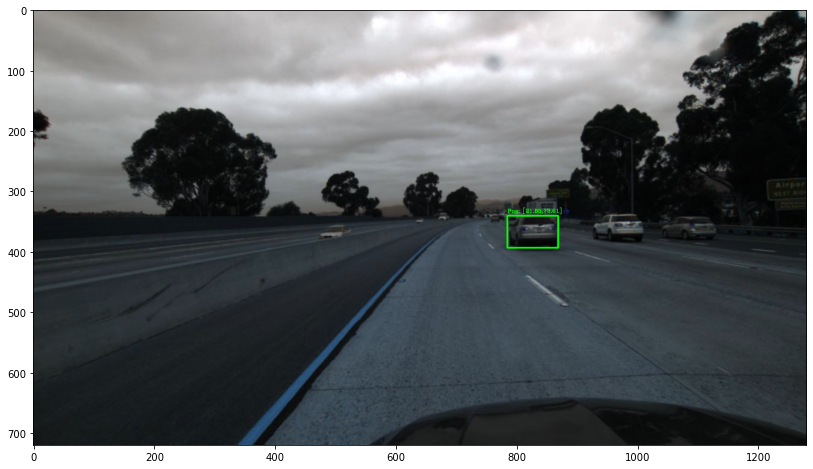

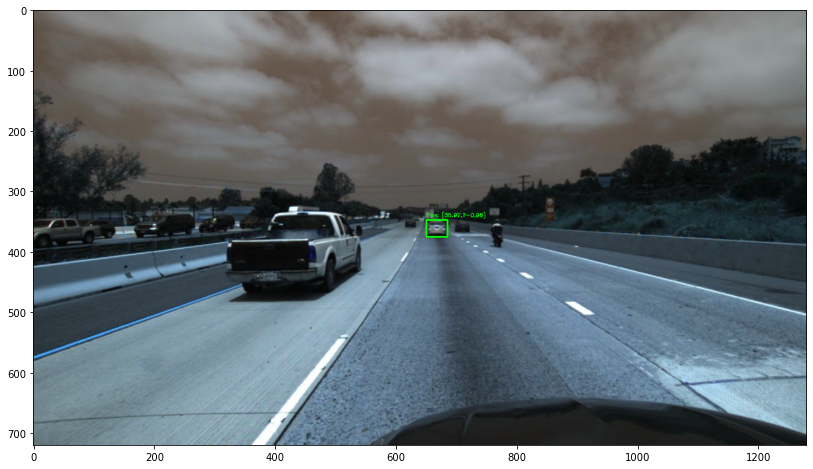

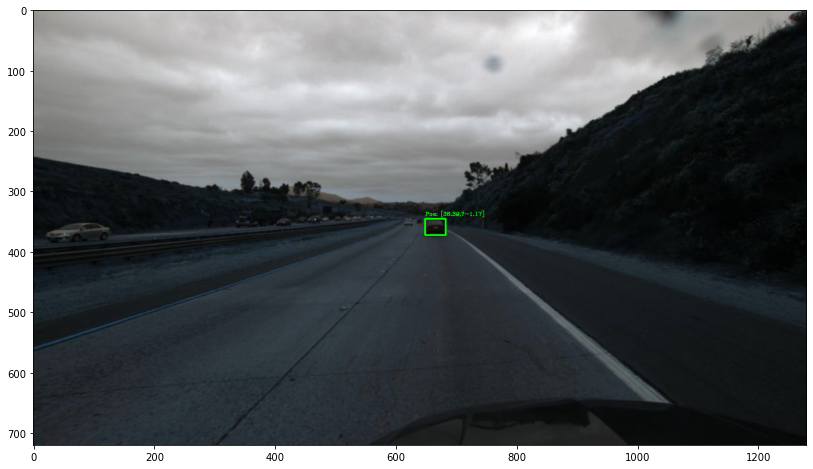

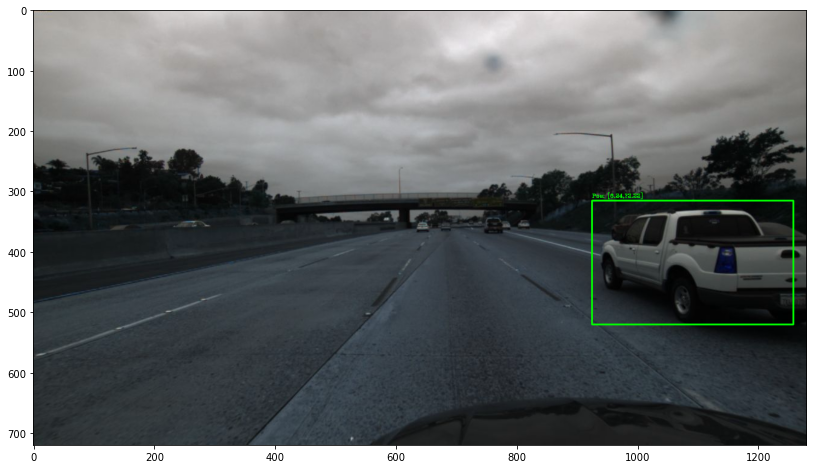

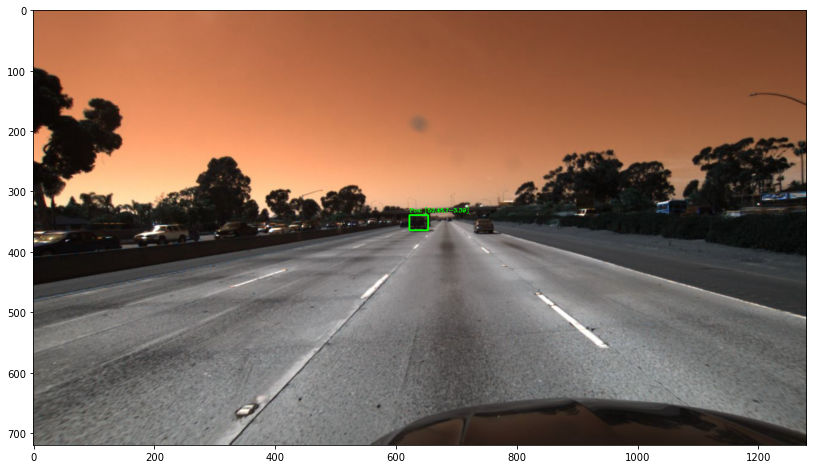

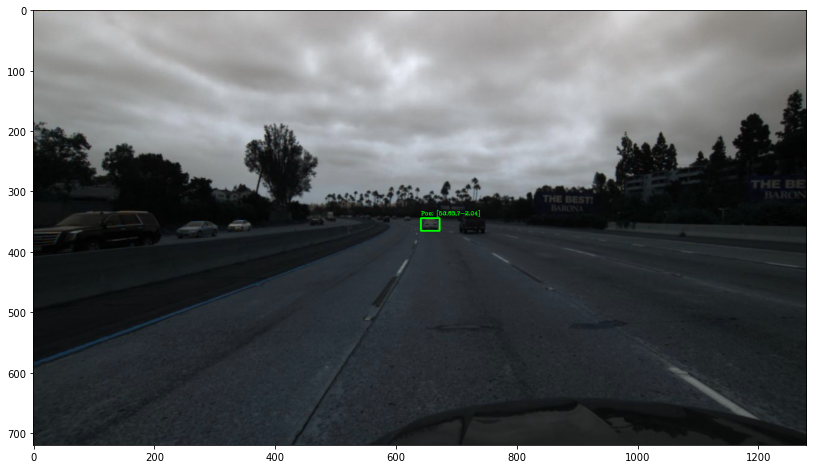

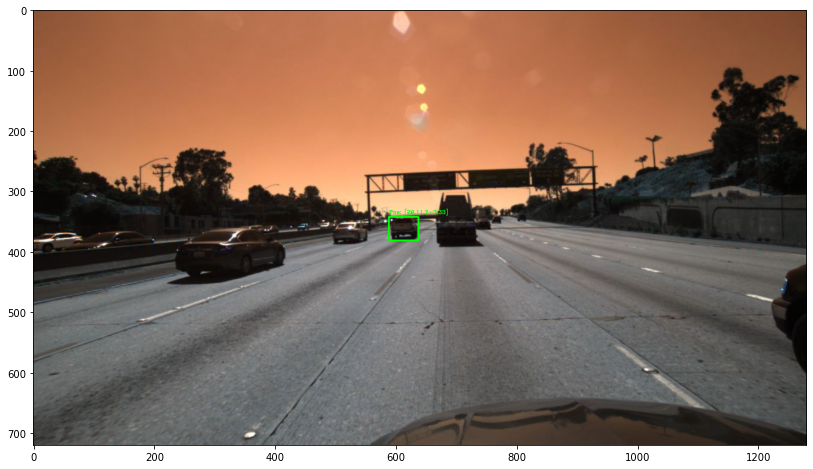

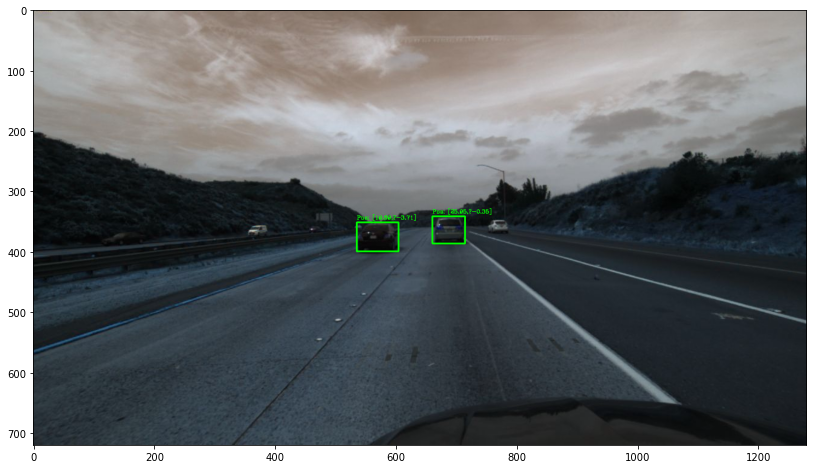

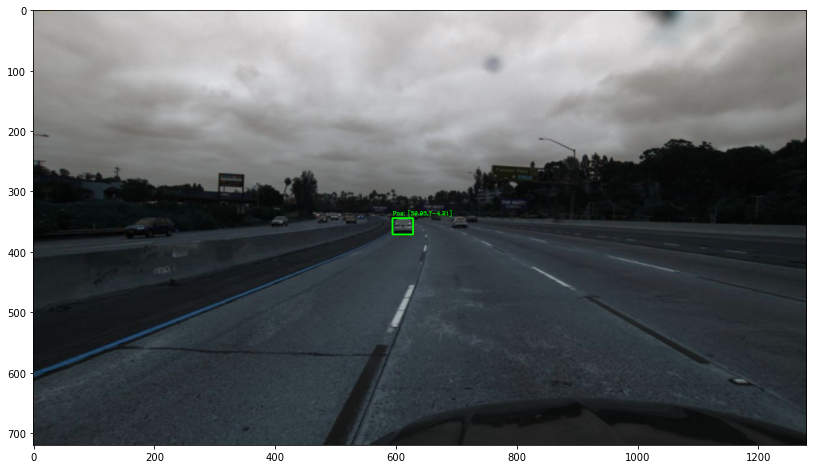

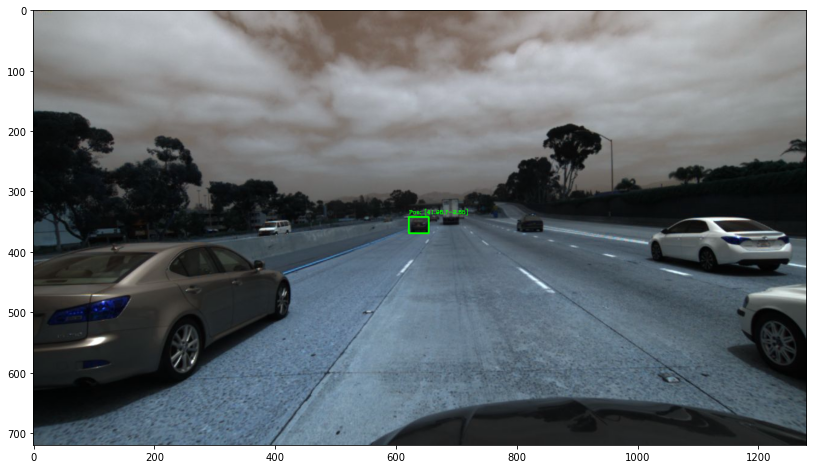

EXPR 2/10 Train_set: AVG Error Z0 1.55, Distance_within_10%_diff_rate: 81.82%, AVG Error X0 0.33, X0_within_10%_rate:81.82%


In [27]:
diff = []
diff_x0 = []
count_z0 = 0
count_x0 = 0
#for i in range(len(images_training_paths)):

for i in range(10):

    img = cv2.imread(images_training_paths[i])
    gt_temp = gt[i]
    cars_info = predict_distance_6(img,gt_temp,flag = 1)

    diff.extend(cars_info[0])
    diff_x0.extend(cars_info[1])
    count_z0 += cars_info[2]
    count_x0 += cars_info[3]

print("EXPR {0}/10 Train_set: AVG Error Z0 {1:.2f}, Distance_within_10%_diff_rate: {2:.2f}%, AVG Error X0 {3:.2f}, X0_within_10%_rate:{4:.2f}%".format(2,np.average(diff),100 * count_z0/len(diff),np.average(diff_x0),100 * count_x0/len(diff_x0)))



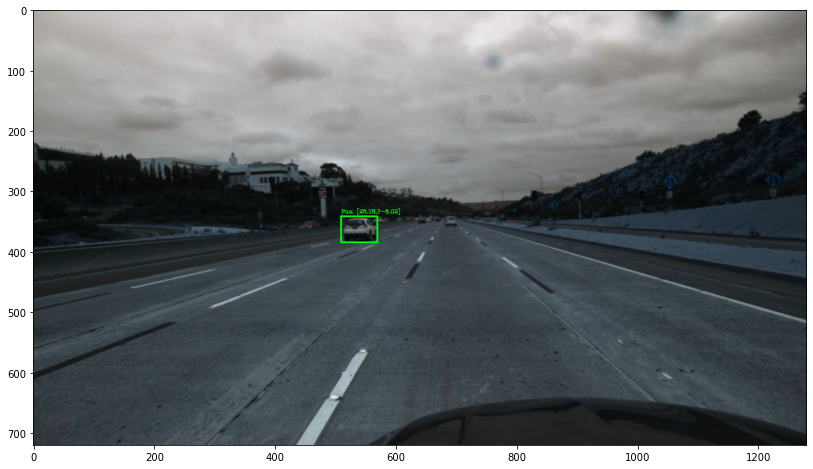

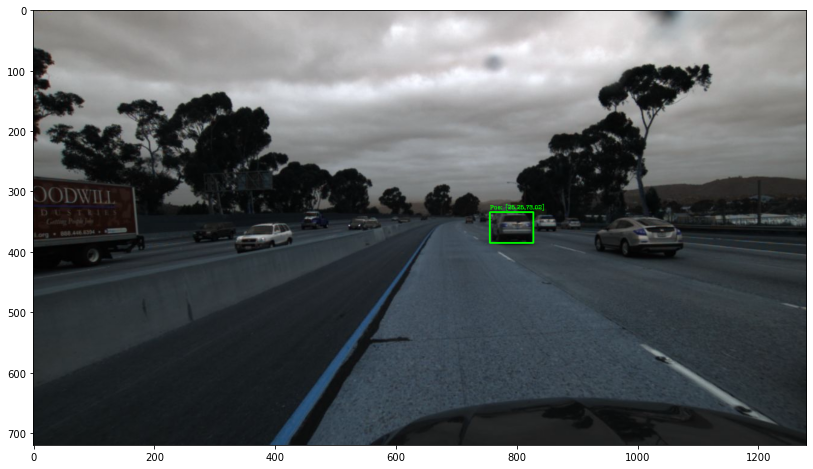

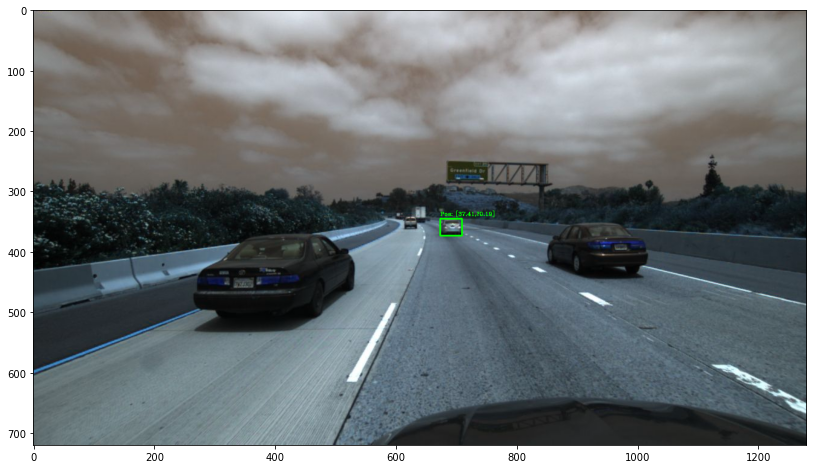

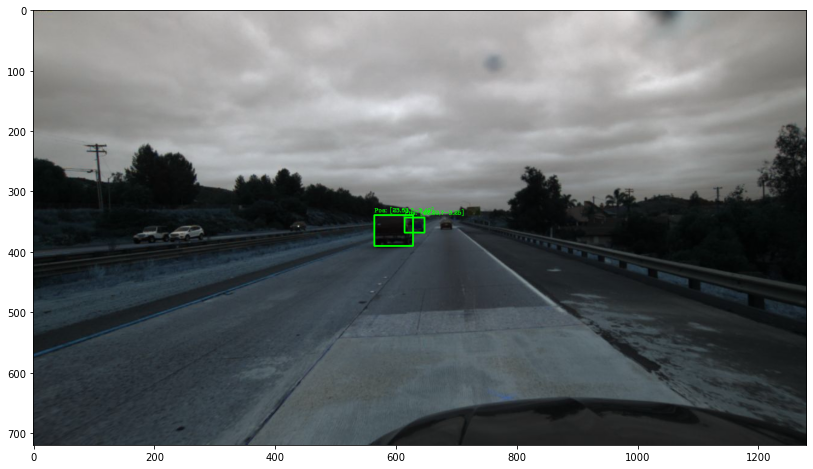

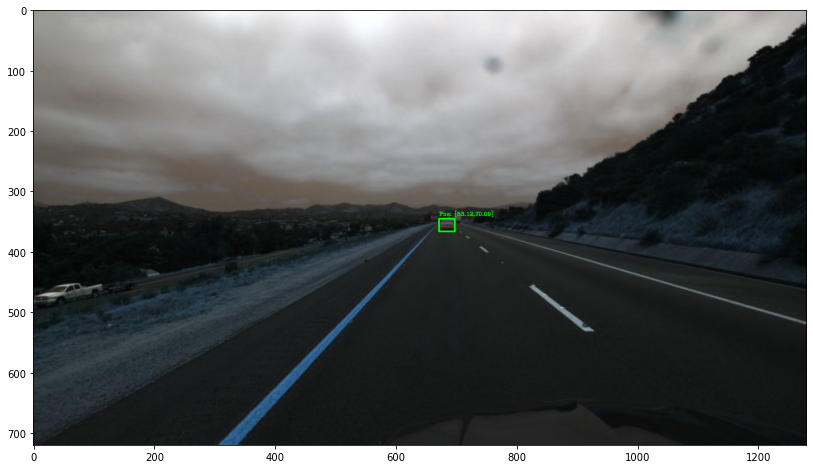

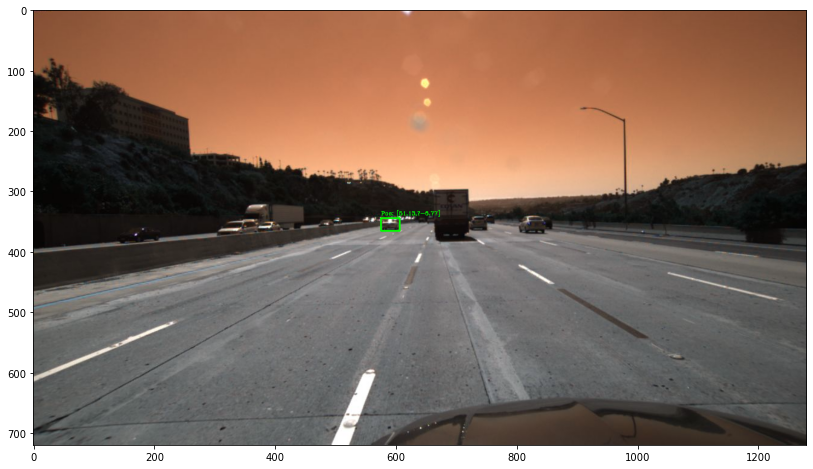

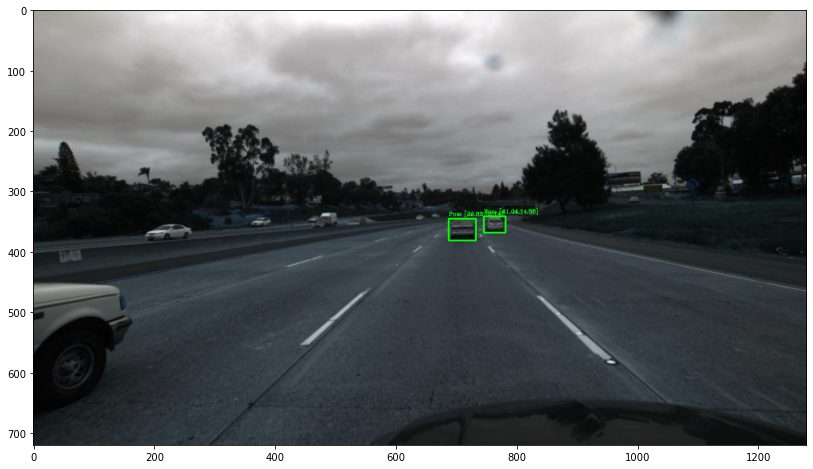

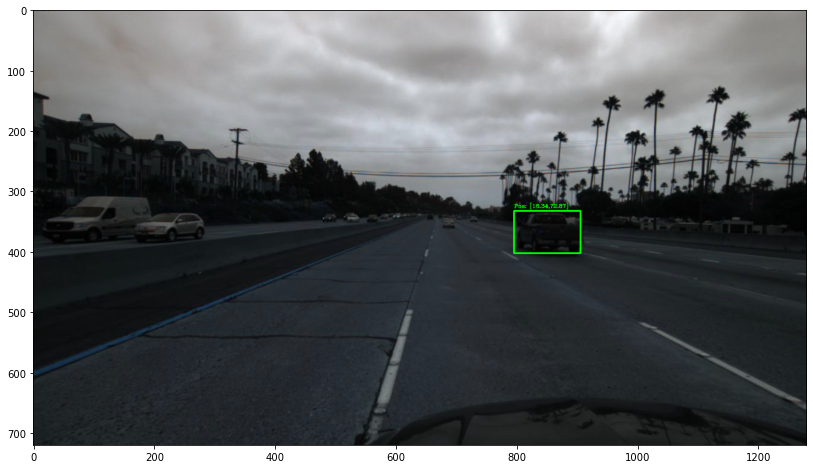

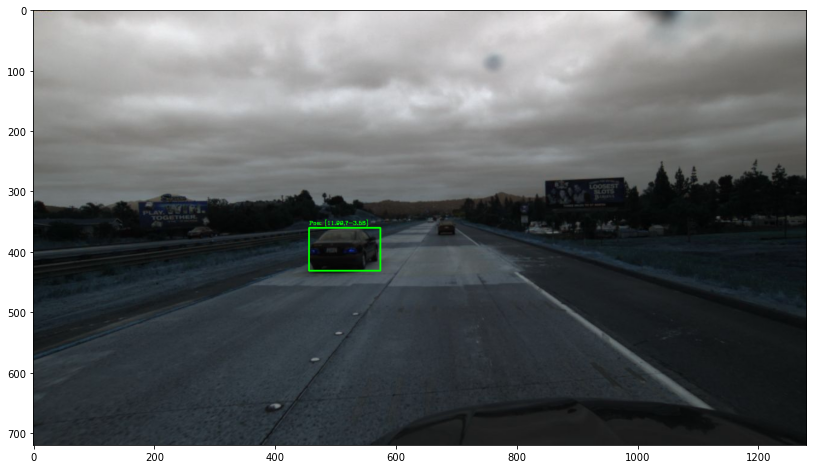

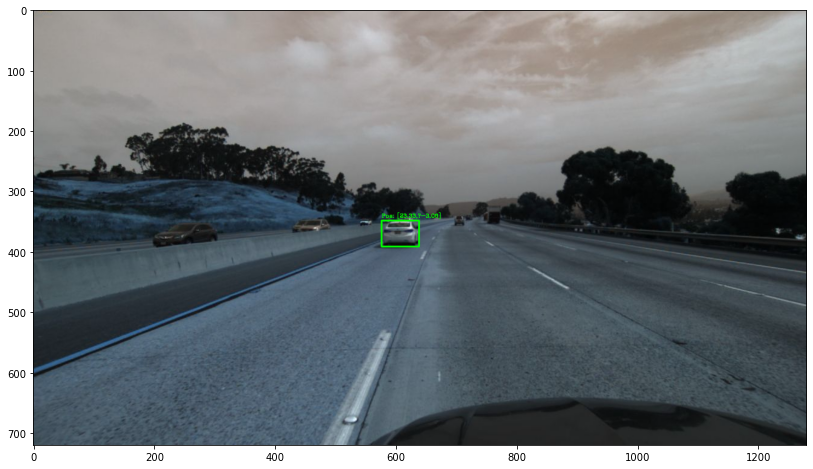

EXPR 2/10 Test_set: AVG Error Z0 1.50, Distance_within_10%_rate: 91.67%, AVG Error X0 0.43, X0_within_10%_rate:83.33%


In [29]:
diff = []
diff_x0 = []
count_z0 = 0
count_x0 = 0
for i in range(10):

    
    gt_temp = gt_t[i]
    #'benchmark_velocity_test/clips/1/imgs/040.jpg'
    img = cv2.imread(f"benchmark_velocity_test/clips/{i+1}/imgs/040.jpg")
    cars_info = predict_distance_6(img,gt_temp,flag =0)
    diff.extend(cars_info[0])
    diff_x0.extend(cars_info[1])
    count_z0 += cars_info[2]
    count_x0 += cars_info[3]
    gt_pred = cars_info[4]
    

print("EXPR {0}/10 Test_set: AVG Error Z0 {1:.2f}, Distance_within_10%_rate: {2:.2f}%, AVG Error X0 {3:.2f}, X0_within_10%_rate:{4:.2f}%".format(2,np.average(diff),100 * count_z0/len(diff),np.average(diff_x0),100 * count_x0/len(diff_x0)))



# Experiments, can be ignored. Considering that we didn't really use the gt distance to make the classification, there might be better threshold then 45 and 20, so I tested them out. It results that the best threshold_far = 45 but the optimal threshold_near = 17 instead of 20. The final code to be submitted will use 20.

In [30]:
def predict_distance_6_testing_threshold(gt,threshold_far,threshold_near,p1 = 670,flag = 1):
    '''Input is a image and the ground truth of this image that includes the position and bbox of cars.
    There could be more than one cars. The cdf of training data and corresponding weights bins
    Output is the difference between the ground truth position and the predicted position'''

    good_z0 = 0
    good_x0 = 0
    cx = 713.85
    
    diff_list = []
    diff_x0_list = []
    gt_pred = copy.deepcopy(gt) #it won't change bbox or velocity and only change position
    fx = 714.1526

    for i in range(len(gt)):
        if flag == 0: #testing data
            x1,x2,y1,y2,z0,x0 = get_v(0,gt[i])
        else:#training data
            x1,x2,y1,y2,z0,x0 = get_v(1,gt[i])


        pixel_w = x2 - x1
        pixel_h = y2 - y1
        
        # initial calculation based on the original model
        w = -0.030522707866872622 * y1 + 0.019645624118997243 * pixel_w -0.026543674714586008* pixel_h + -1.3394041753397261e-05 * pixel_w * pixel_h+ 12.566680966429356
        '''(-0.030522707866872622,
             0.019645624118997243,
             -0.026543674714586008,
             -1.3394041753397261e-05,
             12.566680966429356)'''

        
        pred_z0 = fx * w / pixel_w
        
        #recalculation car width
        
        if pred_z0 > threshold_far:
            #[-0.028121  ,  0.01575292, -0.08113623,  0.00143413]),12.180052129300515
            w = -0.028121 * y1 + 0.01575292 * pixel_w - 0.08113623 * pixel_h +0.00143413 *  pixel_w * pixel_h + 12.180052129300515
        elif pred_z0 <= threshold_far and pred_z0 > threshold_near:
            #[-0.03920957,  0.03809848, -0.02960555, -0.00017222]),15.04862701217894)
            w = -0.03920957 * y1 + 0.03809848 * pixel_w -0.02960555 * pixel_h -0.00017222 *  pixel_w * pixel_h + 15.04862701217894
        else:
            #[-2.23215766e-02,  1.42389457e-02, -2.57650913e-02,  4.97360611e-06]),10.143259937723007)
            w = -2.23215766e-02 * y1 + 1.42389457e-02 * pixel_w -2.57650913e-02 * pixel_h + 4.97360611e-06 *  pixel_w * pixel_h + 10.143259937723007
        
        #recalculate
        pred_z0 = fx * w / pixel_w
        

        pred_x0 = (x1 - p1) * pred_z0/fx
        diff_x0 = x0 - pred_x0
        diff_z0 = z0-pred_z0
        
        gt_pred[i]["position"][0] = pred_z0
        gt_pred[i]["position"][1] = pred_x0
        
        

        if abs(diff_z0)/z0 < 0.10:
            good_z0 +=1
        if abs(diff_x0)/x0 < 0.10:
            good_x0 +=1
        



        diff_x0_list.append(abs(diff_x0))
        diff_list.append(abs(diff_z0))


    return (diff_list,diff_x0_list,good_z0, good_x0,gt_pred)
       

In [31]:
mean_error_distance = math.inf
mean_error_x0 = math.inf
optimal_far = 0
optimal_near = 0

for f in range(40,100): #threshold_far 40 - 100
    for n in range(15,41): #threshold_near 15 40
        diff = []
        diff_x0 = []
        count_z0 = 0
        count_x0 = 0
        for i in range(len(images_training_paths)):
            gt_temp = gt[i]
            cars_info = predict_distance_6_testing_threshold(gt_temp,f,n,flag = 1)

            diff.extend(cars_info[0])
            diff_x0.extend(cars_info[1])
            count_z0 += cars_info[2]
            count_x0 += cars_info[3]
        
        if mean_error_distance >  np.average(diff):
            mean_error_distance =  np.average(diff)
            optimal_far = f
            optimal_near = n
        
            
            
        print(f"threshold_far:{f}, threshold_near: {n}")

        print("EXPR {0}/10 Train_set: AVG Error Z0 {1:.2f}, Distance_within_10%_diff_rate: {2:.2f}%, AVG Error X0 {3:.2f}, X0_within_10%_rate:{4:.2f}%".format(2,np.average(diff),100 * count_z0/len(diff),np.average(diff_x0),100 * count_x0/len(diff_x0)))

        
    

threshold_far:40, threshold_near: 15
EXPR 2/10 Train_set: AVG Error Z0 2.45, Distance_within_10%_diff_rate: 77.53%, AVG Error X0 0.50, X0_within_10%_rate:74.97%
threshold_far:40, threshold_near: 16
EXPR 2/10 Train_set: AVG Error Z0 2.44, Distance_within_10%_diff_rate: 77.95%, AVG Error X0 0.50, X0_within_10%_rate:74.62%
threshold_far:40, threshold_near: 17
EXPR 2/10 Train_set: AVG Error Z0 2.44, Distance_within_10%_diff_rate: 78.02%, AVG Error X0 0.51, X0_within_10%_rate:74.48%
threshold_far:40, threshold_near: 18
EXPR 2/10 Train_set: AVG Error Z0 2.44, Distance_within_10%_diff_rate: 77.81%, AVG Error X0 0.51, X0_within_10%_rate:74.41%
threshold_far:40, threshold_near: 19
EXPR 2/10 Train_set: AVG Error Z0 2.44, Distance_within_10%_diff_rate: 77.95%, AVG Error X0 0.51, X0_within_10%_rate:74.20%
threshold_far:40, threshold_near: 20
EXPR 2/10 Train_set: AVG Error Z0 2.45, Distance_within_10%_diff_rate: 77.60%, AVG Error X0 0.51, X0_within_10%_rate:73.93%
threshold_far:40, threshold_near: 

threshold_far:42, threshold_near: 18
EXPR 2/10 Train_set: AVG Error Z0 2.34, Distance_within_10%_diff_rate: 79.61%, AVG Error X0 0.49, X0_within_10%_rate:74.76%
threshold_far:42, threshold_near: 19
EXPR 2/10 Train_set: AVG Error Z0 2.34, Distance_within_10%_diff_rate: 79.75%, AVG Error X0 0.49, X0_within_10%_rate:74.55%
threshold_far:42, threshold_near: 20
EXPR 2/10 Train_set: AVG Error Z0 2.35, Distance_within_10%_diff_rate: 79.40%, AVG Error X0 0.50, X0_within_10%_rate:74.27%
threshold_far:42, threshold_near: 21
EXPR 2/10 Train_set: AVG Error Z0 2.36, Distance_within_10%_diff_rate: 79.20%, AVG Error X0 0.50, X0_within_10%_rate:74.20%
threshold_far:42, threshold_near: 22
EXPR 2/10 Train_set: AVG Error Z0 2.37, Distance_within_10%_diff_rate: 78.85%, AVG Error X0 0.50, X0_within_10%_rate:74.06%
threshold_far:42, threshold_near: 23
EXPR 2/10 Train_set: AVG Error Z0 2.38, Distance_within_10%_diff_rate: 78.50%, AVG Error X0 0.50, X0_within_10%_rate:74.13%
threshold_far:42, threshold_near: 

threshold_far:44, threshold_near: 22
EXPR 2/10 Train_set: AVG Error Z0 2.31, Distance_within_10%_diff_rate: 79.75%, AVG Error X0 0.49, X0_within_10%_rate:74.13%
threshold_far:44, threshold_near: 23
EXPR 2/10 Train_set: AVG Error Z0 2.33, Distance_within_10%_diff_rate: 79.40%, AVG Error X0 0.50, X0_within_10%_rate:74.20%
threshold_far:44, threshold_near: 24
EXPR 2/10 Train_set: AVG Error Z0 2.33, Distance_within_10%_diff_rate: 79.13%, AVG Error X0 0.50, X0_within_10%_rate:74.06%
threshold_far:44, threshold_near: 25
EXPR 2/10 Train_set: AVG Error Z0 2.35, Distance_within_10%_diff_rate: 78.71%, AVG Error X0 0.50, X0_within_10%_rate:73.99%
threshold_far:44, threshold_near: 26
EXPR 2/10 Train_set: AVG Error Z0 2.37, Distance_within_10%_diff_rate: 78.29%, AVG Error X0 0.50, X0_within_10%_rate:73.99%
threshold_far:44, threshold_near: 27
EXPR 2/10 Train_set: AVG Error Z0 2.40, Distance_within_10%_diff_rate: 77.53%, AVG Error X0 0.51, X0_within_10%_rate:73.99%
threshold_far:44, threshold_near: 

threshold_far:46, threshold_near: 27
EXPR 2/10 Train_set: AVG Error Z0 2.41, Distance_within_10%_diff_rate: 77.88%, AVG Error X0 0.50, X0_within_10%_rate:74.13%
threshold_far:46, threshold_near: 28
EXPR 2/10 Train_set: AVG Error Z0 2.45, Distance_within_10%_diff_rate: 77.32%, AVG Error X0 0.50, X0_within_10%_rate:73.93%
threshold_far:46, threshold_near: 29
EXPR 2/10 Train_set: AVG Error Z0 2.47, Distance_within_10%_diff_rate: 76.49%, AVG Error X0 0.51, X0_within_10%_rate:73.93%
threshold_far:46, threshold_near: 30
EXPR 2/10 Train_set: AVG Error Z0 2.51, Distance_within_10%_diff_rate: 75.52%, AVG Error X0 0.51, X0_within_10%_rate:73.93%
threshold_far:46, threshold_near: 31
EXPR 2/10 Train_set: AVG Error Z0 2.58, Distance_within_10%_diff_rate: 73.86%, AVG Error X0 0.52, X0_within_10%_rate:73.93%
threshold_far:46, threshold_near: 32
EXPR 2/10 Train_set: AVG Error Z0 2.62, Distance_within_10%_diff_rate: 72.95%, AVG Error X0 0.52, X0_within_10%_rate:73.93%
threshold_far:46, threshold_near: 

threshold_far:48, threshold_near: 27
EXPR 2/10 Train_set: AVG Error Z0 2.42, Distance_within_10%_diff_rate: 77.95%, AVG Error X0 0.49, X0_within_10%_rate:74.41%
threshold_far:48, threshold_near: 28
EXPR 2/10 Train_set: AVG Error Z0 2.46, Distance_within_10%_diff_rate: 77.39%, AVG Error X0 0.50, X0_within_10%_rate:74.20%
threshold_far:48, threshold_near: 29
EXPR 2/10 Train_set: AVG Error Z0 2.48, Distance_within_10%_diff_rate: 76.56%, AVG Error X0 0.50, X0_within_10%_rate:74.20%
threshold_far:48, threshold_near: 30
EXPR 2/10 Train_set: AVG Error Z0 2.51, Distance_within_10%_diff_rate: 75.59%, AVG Error X0 0.51, X0_within_10%_rate:74.20%
threshold_far:48, threshold_near: 31
EXPR 2/10 Train_set: AVG Error Z0 2.58, Distance_within_10%_diff_rate: 73.93%, AVG Error X0 0.51, X0_within_10%_rate:74.20%
threshold_far:48, threshold_near: 32
EXPR 2/10 Train_set: AVG Error Z0 2.63, Distance_within_10%_diff_rate: 73.02%, AVG Error X0 0.51, X0_within_10%_rate:74.20%
threshold_far:48, threshold_near: 

threshold_far:50, threshold_near: 30
EXPR 2/10 Train_set: AVG Error Z0 2.54, Distance_within_10%_diff_rate: 75.31%, AVG Error X0 0.50, X0_within_10%_rate:74.27%
threshold_far:50, threshold_near: 31
EXPR 2/10 Train_set: AVG Error Z0 2.61, Distance_within_10%_diff_rate: 73.65%, AVG Error X0 0.51, X0_within_10%_rate:74.27%
threshold_far:50, threshold_near: 32
EXPR 2/10 Train_set: AVG Error Z0 2.65, Distance_within_10%_diff_rate: 72.75%, AVG Error X0 0.51, X0_within_10%_rate:74.27%
threshold_far:50, threshold_near: 33
EXPR 2/10 Train_set: AVG Error Z0 2.71, Distance_within_10%_diff_rate: 72.05%, AVG Error X0 0.52, X0_within_10%_rate:74.13%
threshold_far:50, threshold_near: 34
EXPR 2/10 Train_set: AVG Error Z0 2.74, Distance_within_10%_diff_rate: 71.50%, AVG Error X0 0.52, X0_within_10%_rate:74.13%
threshold_far:50, threshold_near: 35
EXPR 2/10 Train_set: AVG Error Z0 2.78, Distance_within_10%_diff_rate: 70.53%, AVG Error X0 0.52, X0_within_10%_rate:74.13%
threshold_far:50, threshold_near: 

threshold_far:52, threshold_near: 39
EXPR 2/10 Train_set: AVG Error Z0 3.08, Distance_within_10%_diff_rate: 65.33%, AVG Error X0 0.55, X0_within_10%_rate:73.44%
threshold_far:52, threshold_near: 40
EXPR 2/10 Train_set: AVG Error Z0 3.13, Distance_within_10%_diff_rate: 64.36%, AVG Error X0 0.55, X0_within_10%_rate:73.30%
threshold_far:53, threshold_near: 15
EXPR 2/10 Train_set: AVG Error Z0 2.37, Distance_within_10%_diff_rate: 79.82%, AVG Error X0 0.46, X0_within_10%_rate:75.59%
threshold_far:53, threshold_near: 16
EXPR 2/10 Train_set: AVG Error Z0 2.36, Distance_within_10%_diff_rate: 80.24%, AVG Error X0 0.46, X0_within_10%_rate:75.24%
threshold_far:53, threshold_near: 17
EXPR 2/10 Train_set: AVG Error Z0 2.36, Distance_within_10%_diff_rate: 80.31%, AVG Error X0 0.46, X0_within_10%_rate:75.10%
threshold_far:53, threshold_near: 18
EXPR 2/10 Train_set: AVG Error Z0 2.36, Distance_within_10%_diff_rate: 80.10%, AVG Error X0 0.47, X0_within_10%_rate:75.03%
threshold_far:53, threshold_near: 

threshold_far:54, threshold_near: 38
EXPR 2/10 Train_set: AVG Error Z0 2.97, Distance_within_10%_diff_rate: 66.78%, AVG Error X0 0.54, X0_within_10%_rate:73.58%
threshold_far:54, threshold_near: 39
EXPR 2/10 Train_set: AVG Error Z0 3.07, Distance_within_10%_diff_rate: 65.40%, AVG Error X0 0.55, X0_within_10%_rate:73.44%
threshold_far:54, threshold_near: 40
EXPR 2/10 Train_set: AVG Error Z0 3.12, Distance_within_10%_diff_rate: 64.42%, AVG Error X0 0.55, X0_within_10%_rate:73.30%
threshold_far:55, threshold_near: 15
EXPR 2/10 Train_set: AVG Error Z0 2.37, Distance_within_10%_diff_rate: 79.89%, AVG Error X0 0.46, X0_within_10%_rate:75.66%
threshold_far:55, threshold_near: 16
EXPR 2/10 Train_set: AVG Error Z0 2.36, Distance_within_10%_diff_rate: 80.31%, AVG Error X0 0.46, X0_within_10%_rate:75.31%
threshold_far:55, threshold_near: 17
EXPR 2/10 Train_set: AVG Error Z0 2.36, Distance_within_10%_diff_rate: 80.37%, AVG Error X0 0.46, X0_within_10%_rate:75.17%
threshold_far:55, threshold_near: 

threshold_far:57, threshold_near: 16
EXPR 2/10 Train_set: AVG Error Z0 2.38, Distance_within_10%_diff_rate: 80.10%, AVG Error X0 0.46, X0_within_10%_rate:75.24%
threshold_far:57, threshold_near: 17
EXPR 2/10 Train_set: AVG Error Z0 2.38, Distance_within_10%_diff_rate: 80.17%, AVG Error X0 0.46, X0_within_10%_rate:75.10%
threshold_far:57, threshold_near: 18
EXPR 2/10 Train_set: AVG Error Z0 2.38, Distance_within_10%_diff_rate: 79.96%, AVG Error X0 0.46, X0_within_10%_rate:75.03%
threshold_far:57, threshold_near: 19
EXPR 2/10 Train_set: AVG Error Z0 2.38, Distance_within_10%_diff_rate: 80.10%, AVG Error X0 0.46, X0_within_10%_rate:74.83%
threshold_far:57, threshold_near: 20
EXPR 2/10 Train_set: AVG Error Z0 2.39, Distance_within_10%_diff_rate: 79.75%, AVG Error X0 0.47, X0_within_10%_rate:74.55%
threshold_far:57, threshold_near: 21
EXPR 2/10 Train_set: AVG Error Z0 2.40, Distance_within_10%_diff_rate: 79.54%, AVG Error X0 0.47, X0_within_10%_rate:74.48%
threshold_far:57, threshold_near: 

threshold_far:59, threshold_near: 19
EXPR 2/10 Train_set: AVG Error Z0 2.38, Distance_within_10%_diff_rate: 79.89%, AVG Error X0 0.46, X0_within_10%_rate:74.97%
threshold_far:59, threshold_near: 20
EXPR 2/10 Train_set: AVG Error Z0 2.39, Distance_within_10%_diff_rate: 79.54%, AVG Error X0 0.47, X0_within_10%_rate:74.69%
threshold_far:59, threshold_near: 21
EXPR 2/10 Train_set: AVG Error Z0 2.40, Distance_within_10%_diff_rate: 79.33%, AVG Error X0 0.47, X0_within_10%_rate:74.62%
threshold_far:59, threshold_near: 22
EXPR 2/10 Train_set: AVG Error Z0 2.41, Distance_within_10%_diff_rate: 78.99%, AVG Error X0 0.47, X0_within_10%_rate:74.48%
threshold_far:59, threshold_near: 23
EXPR 2/10 Train_set: AVG Error Z0 2.43, Distance_within_10%_diff_rate: 78.64%, AVG Error X0 0.47, X0_within_10%_rate:74.55%
threshold_far:59, threshold_near: 24
EXPR 2/10 Train_set: AVG Error Z0 2.43, Distance_within_10%_diff_rate: 78.36%, AVG Error X0 0.47, X0_within_10%_rate:74.41%
threshold_far:59, threshold_near: 

threshold_far:61, threshold_near: 26
EXPR 2/10 Train_set: AVG Error Z0 2.47, Distance_within_10%_diff_rate: 77.67%, AVG Error X0 0.48, X0_within_10%_rate:74.41%
threshold_far:61, threshold_near: 27
EXPR 2/10 Train_set: AVG Error Z0 2.51, Distance_within_10%_diff_rate: 76.91%, AVG Error X0 0.48, X0_within_10%_rate:74.41%
threshold_far:61, threshold_near: 28
EXPR 2/10 Train_set: AVG Error Z0 2.55, Distance_within_10%_diff_rate: 76.35%, AVG Error X0 0.49, X0_within_10%_rate:74.20%
threshold_far:61, threshold_near: 29
EXPR 2/10 Train_set: AVG Error Z0 2.57, Distance_within_10%_diff_rate: 75.52%, AVG Error X0 0.49, X0_within_10%_rate:74.20%
threshold_far:61, threshold_near: 30
EXPR 2/10 Train_set: AVG Error Z0 2.61, Distance_within_10%_diff_rate: 74.55%, AVG Error X0 0.50, X0_within_10%_rate:74.20%
threshold_far:61, threshold_near: 31
EXPR 2/10 Train_set: AVG Error Z0 2.68, Distance_within_10%_diff_rate: 72.88%, AVG Error X0 0.50, X0_within_10%_rate:74.20%
threshold_far:61, threshold_near: 

threshold_far:63, threshold_near: 34
EXPR 2/10 Train_set: AVG Error Z0 2.82, Distance_within_10%_diff_rate: 70.60%, AVG Error X0 0.51, X0_within_10%_rate:74.06%
threshold_far:63, threshold_near: 35
EXPR 2/10 Train_set: AVG Error Z0 2.86, Distance_within_10%_diff_rate: 69.63%, AVG Error X0 0.52, X0_within_10%_rate:74.06%
threshold_far:63, threshold_near: 36
EXPR 2/10 Train_set: AVG Error Z0 2.91, Distance_within_10%_diff_rate: 68.45%, AVG Error X0 0.53, X0_within_10%_rate:73.99%
threshold_far:63, threshold_near: 37
EXPR 2/10 Train_set: AVG Error Z0 2.98, Distance_within_10%_diff_rate: 67.06%, AVG Error X0 0.53, X0_within_10%_rate:73.86%
threshold_far:63, threshold_near: 38
EXPR 2/10 Train_set: AVG Error Z0 3.02, Distance_within_10%_diff_rate: 66.37%, AVG Error X0 0.54, X0_within_10%_rate:73.79%
threshold_far:63, threshold_near: 39
EXPR 2/10 Train_set: AVG Error Z0 3.12, Distance_within_10%_diff_rate: 64.98%, AVG Error X0 0.54, X0_within_10%_rate:73.65%
threshold_far:63, threshold_near: 

threshold_far:66, threshold_near: 17
EXPR 2/10 Train_set: AVG Error Z0 2.40, Distance_within_10%_diff_rate: 79.96%, AVG Error X0 0.46, X0_within_10%_rate:75.31%
threshold_far:66, threshold_near: 18
EXPR 2/10 Train_set: AVG Error Z0 2.40, Distance_within_10%_diff_rate: 79.75%, AVG Error X0 0.46, X0_within_10%_rate:75.24%
threshold_far:66, threshold_near: 19
EXPR 2/10 Train_set: AVG Error Z0 2.40, Distance_within_10%_diff_rate: 79.89%, AVG Error X0 0.46, X0_within_10%_rate:75.03%
threshold_far:66, threshold_near: 20
EXPR 2/10 Train_set: AVG Error Z0 2.42, Distance_within_10%_diff_rate: 79.54%, AVG Error X0 0.47, X0_within_10%_rate:74.76%
threshold_far:66, threshold_near: 21
EXPR 2/10 Train_set: AVG Error Z0 2.42, Distance_within_10%_diff_rate: 79.33%, AVG Error X0 0.47, X0_within_10%_rate:74.69%
threshold_far:66, threshold_near: 22
EXPR 2/10 Train_set: AVG Error Z0 2.43, Distance_within_10%_diff_rate: 78.99%, AVG Error X0 0.47, X0_within_10%_rate:74.55%
threshold_far:66, threshold_near: 

threshold_far:68, threshold_near: 18
EXPR 2/10 Train_set: AVG Error Z0 2.42, Distance_within_10%_diff_rate: 79.75%, AVG Error X0 0.46, X0_within_10%_rate:75.24%
threshold_far:68, threshold_near: 19
EXPR 2/10 Train_set: AVG Error Z0 2.42, Distance_within_10%_diff_rate: 79.89%, AVG Error X0 0.46, X0_within_10%_rate:75.03%
threshold_far:68, threshold_near: 20
EXPR 2/10 Train_set: AVG Error Z0 2.43, Distance_within_10%_diff_rate: 79.54%, AVG Error X0 0.47, X0_within_10%_rate:74.76%
threshold_far:68, threshold_near: 21
EXPR 2/10 Train_set: AVG Error Z0 2.44, Distance_within_10%_diff_rate: 79.33%, AVG Error X0 0.47, X0_within_10%_rate:74.69%
threshold_far:68, threshold_near: 22
EXPR 2/10 Train_set: AVG Error Z0 2.45, Distance_within_10%_diff_rate: 78.99%, AVG Error X0 0.47, X0_within_10%_rate:74.55%
threshold_far:68, threshold_near: 23
EXPR 2/10 Train_set: AVG Error Z0 2.46, Distance_within_10%_diff_rate: 78.64%, AVG Error X0 0.47, X0_within_10%_rate:74.62%
threshold_far:68, threshold_near: 

threshold_far:70, threshold_near: 29
EXPR 2/10 Train_set: AVG Error Z0 2.59, Distance_within_10%_diff_rate: 75.52%, AVG Error X0 0.49, X0_within_10%_rate:74.20%
threshold_far:70, threshold_near: 30
EXPR 2/10 Train_set: AVG Error Z0 2.63, Distance_within_10%_diff_rate: 74.55%, AVG Error X0 0.49, X0_within_10%_rate:74.20%
threshold_far:70, threshold_near: 31
EXPR 2/10 Train_set: AVG Error Z0 2.70, Distance_within_10%_diff_rate: 72.88%, AVG Error X0 0.50, X0_within_10%_rate:74.20%
threshold_far:70, threshold_near: 32
EXPR 2/10 Train_set: AVG Error Z0 2.74, Distance_within_10%_diff_rate: 71.98%, AVG Error X0 0.50, X0_within_10%_rate:74.20%
threshold_far:70, threshold_near: 33
EXPR 2/10 Train_set: AVG Error Z0 2.80, Distance_within_10%_diff_rate: 71.29%, AVG Error X0 0.51, X0_within_10%_rate:74.06%
threshold_far:70, threshold_near: 34
EXPR 2/10 Train_set: AVG Error Z0 2.83, Distance_within_10%_diff_rate: 70.74%, AVG Error X0 0.51, X0_within_10%_rate:74.06%
threshold_far:70, threshold_near: 

threshold_far:72, threshold_near: 40
EXPR 2/10 Train_set: AVG Error Z0 3.19, Distance_within_10%_diff_rate: 64.15%, AVG Error X0 0.55, X0_within_10%_rate:73.51%
threshold_far:73, threshold_near: 15
EXPR 2/10 Train_set: AVG Error Z0 2.43, Distance_within_10%_diff_rate: 79.61%, AVG Error X0 0.45, X0_within_10%_rate:75.80%
threshold_far:73, threshold_near: 16
EXPR 2/10 Train_set: AVG Error Z0 2.42, Distance_within_10%_diff_rate: 80.03%, AVG Error X0 0.46, X0_within_10%_rate:75.45%
threshold_far:73, threshold_near: 17
EXPR 2/10 Train_set: AVG Error Z0 2.42, Distance_within_10%_diff_rate: 80.10%, AVG Error X0 0.46, X0_within_10%_rate:75.31%
threshold_far:73, threshold_near: 18
EXPR 2/10 Train_set: AVG Error Z0 2.42, Distance_within_10%_diff_rate: 79.89%, AVG Error X0 0.46, X0_within_10%_rate:75.24%
threshold_far:73, threshold_near: 19
EXPR 2/10 Train_set: AVG Error Z0 2.42, Distance_within_10%_diff_rate: 80.03%, AVG Error X0 0.46, X0_within_10%_rate:75.03%
threshold_far:73, threshold_near: 

threshold_far:75, threshold_near: 22
EXPR 2/10 Train_set: AVG Error Z0 2.45, Distance_within_10%_diff_rate: 79.13%, AVG Error X0 0.47, X0_within_10%_rate:74.55%
threshold_far:75, threshold_near: 23
EXPR 2/10 Train_set: AVG Error Z0 2.47, Distance_within_10%_diff_rate: 78.78%, AVG Error X0 0.47, X0_within_10%_rate:74.62%
threshold_far:75, threshold_near: 24
EXPR 2/10 Train_set: AVG Error Z0 2.47, Distance_within_10%_diff_rate: 78.50%, AVG Error X0 0.47, X0_within_10%_rate:74.48%
threshold_far:75, threshold_near: 25
EXPR 2/10 Train_set: AVG Error Z0 2.49, Distance_within_10%_diff_rate: 78.09%, AVG Error X0 0.47, X0_within_10%_rate:74.41%
threshold_far:75, threshold_near: 26
EXPR 2/10 Train_set: AVG Error Z0 2.50, Distance_within_10%_diff_rate: 77.67%, AVG Error X0 0.48, X0_within_10%_rate:74.41%
threshold_far:75, threshold_near: 27
EXPR 2/10 Train_set: AVG Error Z0 2.54, Distance_within_10%_diff_rate: 76.91%, AVG Error X0 0.48, X0_within_10%_rate:74.41%
threshold_far:75, threshold_near: 

threshold_far:77, threshold_near: 31
EXPR 2/10 Train_set: AVG Error Z0 2.71, Distance_within_10%_diff_rate: 72.88%, AVG Error X0 0.50, X0_within_10%_rate:74.20%
threshold_far:77, threshold_near: 32
EXPR 2/10 Train_set: AVG Error Z0 2.76, Distance_within_10%_diff_rate: 71.98%, AVG Error X0 0.50, X0_within_10%_rate:74.20%
threshold_far:77, threshold_near: 33
EXPR 2/10 Train_set: AVG Error Z0 2.81, Distance_within_10%_diff_rate: 71.29%, AVG Error X0 0.51, X0_within_10%_rate:74.06%
threshold_far:77, threshold_near: 34
EXPR 2/10 Train_set: AVG Error Z0 2.84, Distance_within_10%_diff_rate: 70.74%, AVG Error X0 0.51, X0_within_10%_rate:74.06%
threshold_far:77, threshold_near: 35
EXPR 2/10 Train_set: AVG Error Z0 2.89, Distance_within_10%_diff_rate: 69.76%, AVG Error X0 0.52, X0_within_10%_rate:74.06%
threshold_far:77, threshold_near: 36
EXPR 2/10 Train_set: AVG Error Z0 2.94, Distance_within_10%_diff_rate: 68.59%, AVG Error X0 0.52, X0_within_10%_rate:73.99%
threshold_far:77, threshold_near: 

threshold_far:79, threshold_near: 37
EXPR 2/10 Train_set: AVG Error Z0 3.01, Distance_within_10%_diff_rate: 67.20%, AVG Error X0 0.53, X0_within_10%_rate:73.86%
threshold_far:79, threshold_near: 38
EXPR 2/10 Train_set: AVG Error Z0 3.04, Distance_within_10%_diff_rate: 66.50%, AVG Error X0 0.53, X0_within_10%_rate:73.79%
threshold_far:79, threshold_near: 39
EXPR 2/10 Train_set: AVG Error Z0 3.14, Distance_within_10%_diff_rate: 65.12%, AVG Error X0 0.54, X0_within_10%_rate:73.65%
threshold_far:79, threshold_near: 40
EXPR 2/10 Train_set: AVG Error Z0 3.19, Distance_within_10%_diff_rate: 64.15%, AVG Error X0 0.54, X0_within_10%_rate:73.51%
threshold_far:80, threshold_near: 15
EXPR 2/10 Train_set: AVG Error Z0 2.43, Distance_within_10%_diff_rate: 79.61%, AVG Error X0 0.45, X0_within_10%_rate:75.80%
threshold_far:80, threshold_near: 16
EXPR 2/10 Train_set: AVG Error Z0 2.42, Distance_within_10%_diff_rate: 80.03%, AVG Error X0 0.45, X0_within_10%_rate:75.45%
threshold_far:80, threshold_near: 

threshold_far:82, threshold_near: 16
EXPR 2/10 Train_set: AVG Error Z0 2.43, Distance_within_10%_diff_rate: 80.03%, AVG Error X0 0.46, X0_within_10%_rate:75.38%
threshold_far:82, threshold_near: 17
EXPR 2/10 Train_set: AVG Error Z0 2.43, Distance_within_10%_diff_rate: 80.10%, AVG Error X0 0.46, X0_within_10%_rate:75.24%
threshold_far:82, threshold_near: 18
EXPR 2/10 Train_set: AVG Error Z0 2.43, Distance_within_10%_diff_rate: 79.89%, AVG Error X0 0.46, X0_within_10%_rate:75.17%
threshold_far:82, threshold_near: 19
EXPR 2/10 Train_set: AVG Error Z0 2.43, Distance_within_10%_diff_rate: 80.03%, AVG Error X0 0.46, X0_within_10%_rate:74.97%
threshold_far:82, threshold_near: 20
EXPR 2/10 Train_set: AVG Error Z0 2.44, Distance_within_10%_diff_rate: 79.68%, AVG Error X0 0.46, X0_within_10%_rate:74.69%
threshold_far:82, threshold_near: 21
EXPR 2/10 Train_set: AVG Error Z0 2.45, Distance_within_10%_diff_rate: 79.47%, AVG Error X0 0.47, X0_within_10%_rate:74.62%
threshold_far:82, threshold_near: 

threshold_far:84, threshold_near: 20
EXPR 2/10 Train_set: AVG Error Z0 2.45, Distance_within_10%_diff_rate: 79.68%, AVG Error X0 0.46, X0_within_10%_rate:74.69%
threshold_far:84, threshold_near: 21
EXPR 2/10 Train_set: AVG Error Z0 2.46, Distance_within_10%_diff_rate: 79.47%, AVG Error X0 0.47, X0_within_10%_rate:74.62%
threshold_far:84, threshold_near: 22
EXPR 2/10 Train_set: AVG Error Z0 2.46, Distance_within_10%_diff_rate: 79.13%, AVG Error X0 0.47, X0_within_10%_rate:74.48%
threshold_far:84, threshold_near: 23
EXPR 2/10 Train_set: AVG Error Z0 2.48, Distance_within_10%_diff_rate: 78.78%, AVG Error X0 0.47, X0_within_10%_rate:74.55%
threshold_far:84, threshold_near: 24
EXPR 2/10 Train_set: AVG Error Z0 2.48, Distance_within_10%_diff_rate: 78.50%, AVG Error X0 0.47, X0_within_10%_rate:74.41%
threshold_far:84, threshold_near: 25
EXPR 2/10 Train_set: AVG Error Z0 2.50, Distance_within_10%_diff_rate: 78.09%, AVG Error X0 0.47, X0_within_10%_rate:74.34%
threshold_far:84, threshold_near: 

threshold_far:86, threshold_near: 24
EXPR 2/10 Train_set: AVG Error Z0 2.48, Distance_within_10%_diff_rate: 78.50%, AVG Error X0 0.47, X0_within_10%_rate:74.41%
threshold_far:86, threshold_near: 25
EXPR 2/10 Train_set: AVG Error Z0 2.50, Distance_within_10%_diff_rate: 78.09%, AVG Error X0 0.47, X0_within_10%_rate:74.34%
threshold_far:86, threshold_near: 26
EXPR 2/10 Train_set: AVG Error Z0 2.52, Distance_within_10%_diff_rate: 77.67%, AVG Error X0 0.48, X0_within_10%_rate:74.34%
threshold_far:86, threshold_near: 27
EXPR 2/10 Train_set: AVG Error Z0 2.55, Distance_within_10%_diff_rate: 76.91%, AVG Error X0 0.48, X0_within_10%_rate:74.34%
threshold_far:86, threshold_near: 28
EXPR 2/10 Train_set: AVG Error Z0 2.59, Distance_within_10%_diff_rate: 76.35%, AVG Error X0 0.48, X0_within_10%_rate:74.13%
threshold_far:86, threshold_near: 29
EXPR 2/10 Train_set: AVG Error Z0 2.62, Distance_within_10%_diff_rate: 75.52%, AVG Error X0 0.49, X0_within_10%_rate:74.13%
threshold_far:86, threshold_near: 

threshold_far:88, threshold_near: 31
EXPR 2/10 Train_set: AVG Error Z0 2.72, Distance_within_10%_diff_rate: 72.88%, AVG Error X0 0.50, X0_within_10%_rate:74.13%
threshold_far:88, threshold_near: 32
EXPR 2/10 Train_set: AVG Error Z0 2.77, Distance_within_10%_diff_rate: 71.98%, AVG Error X0 0.50, X0_within_10%_rate:74.13%
threshold_far:88, threshold_near: 33
EXPR 2/10 Train_set: AVG Error Z0 2.82, Distance_within_10%_diff_rate: 71.29%, AVG Error X0 0.51, X0_within_10%_rate:73.99%
threshold_far:88, threshold_near: 34
EXPR 2/10 Train_set: AVG Error Z0 2.85, Distance_within_10%_diff_rate: 70.74%, AVG Error X0 0.51, X0_within_10%_rate:73.99%
threshold_far:88, threshold_near: 35
EXPR 2/10 Train_set: AVG Error Z0 2.90, Distance_within_10%_diff_rate: 69.76%, AVG Error X0 0.52, X0_within_10%_rate:73.99%
threshold_far:88, threshold_near: 36
EXPR 2/10 Train_set: AVG Error Z0 2.95, Distance_within_10%_diff_rate: 68.59%, AVG Error X0 0.52, X0_within_10%_rate:73.93%
threshold_far:88, threshold_near: 

threshold_far:90, threshold_near: 38
EXPR 2/10 Train_set: AVG Error Z0 3.05, Distance_within_10%_diff_rate: 66.50%, AVG Error X0 0.53, X0_within_10%_rate:73.72%
threshold_far:90, threshold_near: 39
EXPR 2/10 Train_set: AVG Error Z0 3.15, Distance_within_10%_diff_rate: 65.12%, AVG Error X0 0.54, X0_within_10%_rate:73.58%
threshold_far:90, threshold_near: 40
EXPR 2/10 Train_set: AVG Error Z0 3.20, Distance_within_10%_diff_rate: 64.15%, AVG Error X0 0.54, X0_within_10%_rate:73.44%
threshold_far:91, threshold_near: 15
EXPR 2/10 Train_set: AVG Error Z0 2.44, Distance_within_10%_diff_rate: 79.61%, AVG Error X0 0.45, X0_within_10%_rate:75.73%
threshold_far:91, threshold_near: 16
EXPR 2/10 Train_set: AVG Error Z0 2.43, Distance_within_10%_diff_rate: 80.03%, AVG Error X0 0.45, X0_within_10%_rate:75.38%
threshold_far:91, threshold_near: 17
EXPR 2/10 Train_set: AVG Error Z0 2.43, Distance_within_10%_diff_rate: 80.10%, AVG Error X0 0.46, X0_within_10%_rate:75.24%
threshold_far:91, threshold_near: 

threshold_far:93, threshold_near: 21
EXPR 2/10 Train_set: AVG Error Z0 2.46, Distance_within_10%_diff_rate: 79.47%, AVG Error X0 0.47, X0_within_10%_rate:74.62%
threshold_far:93, threshold_near: 22
EXPR 2/10 Train_set: AVG Error Z0 2.47, Distance_within_10%_diff_rate: 79.13%, AVG Error X0 0.47, X0_within_10%_rate:74.48%
threshold_far:93, threshold_near: 23
EXPR 2/10 Train_set: AVG Error Z0 2.48, Distance_within_10%_diff_rate: 78.78%, AVG Error X0 0.47, X0_within_10%_rate:74.55%
threshold_far:93, threshold_near: 24
EXPR 2/10 Train_set: AVG Error Z0 2.48, Distance_within_10%_diff_rate: 78.50%, AVG Error X0 0.47, X0_within_10%_rate:74.41%
threshold_far:93, threshold_near: 25
EXPR 2/10 Train_set: AVG Error Z0 2.50, Distance_within_10%_diff_rate: 78.09%, AVG Error X0 0.47, X0_within_10%_rate:74.34%
threshold_far:93, threshold_near: 26
EXPR 2/10 Train_set: AVG Error Z0 2.52, Distance_within_10%_diff_rate: 77.67%, AVG Error X0 0.48, X0_within_10%_rate:74.34%
threshold_far:93, threshold_near: 

threshold_far:95, threshold_near: 29
EXPR 2/10 Train_set: AVG Error Z0 2.62, Distance_within_10%_diff_rate: 75.52%, AVG Error X0 0.49, X0_within_10%_rate:74.13%
threshold_far:95, threshold_near: 30
EXPR 2/10 Train_set: AVG Error Z0 2.65, Distance_within_10%_diff_rate: 74.55%, AVG Error X0 0.49, X0_within_10%_rate:74.13%
threshold_far:95, threshold_near: 31
EXPR 2/10 Train_set: AVG Error Z0 2.72, Distance_within_10%_diff_rate: 72.88%, AVG Error X0 0.50, X0_within_10%_rate:74.13%
threshold_far:95, threshold_near: 32
EXPR 2/10 Train_set: AVG Error Z0 2.77, Distance_within_10%_diff_rate: 71.98%, AVG Error X0 0.50, X0_within_10%_rate:74.13%
threshold_far:95, threshold_near: 33
EXPR 2/10 Train_set: AVG Error Z0 2.82, Distance_within_10%_diff_rate: 71.29%, AVG Error X0 0.51, X0_within_10%_rate:73.99%
threshold_far:95, threshold_near: 34
EXPR 2/10 Train_set: AVG Error Z0 2.85, Distance_within_10%_diff_rate: 70.74%, AVG Error X0 0.51, X0_within_10%_rate:73.99%
threshold_far:95, threshold_near: 

threshold_far:97, threshold_near: 31
EXPR 2/10 Train_set: AVG Error Z0 2.72, Distance_within_10%_diff_rate: 72.88%, AVG Error X0 0.50, X0_within_10%_rate:74.13%
threshold_far:97, threshold_near: 32
EXPR 2/10 Train_set: AVG Error Z0 2.77, Distance_within_10%_diff_rate: 71.98%, AVG Error X0 0.50, X0_within_10%_rate:74.13%
threshold_far:97, threshold_near: 33
EXPR 2/10 Train_set: AVG Error Z0 2.82, Distance_within_10%_diff_rate: 71.29%, AVG Error X0 0.51, X0_within_10%_rate:73.99%
threshold_far:97, threshold_near: 34
EXPR 2/10 Train_set: AVG Error Z0 2.85, Distance_within_10%_diff_rate: 70.74%, AVG Error X0 0.51, X0_within_10%_rate:73.99%
threshold_far:97, threshold_near: 35
EXPR 2/10 Train_set: AVG Error Z0 2.90, Distance_within_10%_diff_rate: 69.76%, AVG Error X0 0.52, X0_within_10%_rate:73.99%
threshold_far:97, threshold_near: 36
EXPR 2/10 Train_set: AVG Error Z0 2.95, Distance_within_10%_diff_rate: 68.59%, AVG Error X0 0.52, X0_within_10%_rate:73.93%
threshold_far:97, threshold_near: 

threshold_far:99, threshold_near: 39
EXPR 2/10 Train_set: AVG Error Z0 3.15, Distance_within_10%_diff_rate: 65.12%, AVG Error X0 0.54, X0_within_10%_rate:73.58%
threshold_far:99, threshold_near: 40
EXPR 2/10 Train_set: AVG Error Z0 3.20, Distance_within_10%_diff_rate: 64.15%, AVG Error X0 0.54, X0_within_10%_rate:73.44%


In [32]:
mean_error_distance,optimal_far ,optimal_near 

(2.275503185467094, 45, 17)

In [35]:

pred = copy.deepcopy(gt)
for i in range(len(images_training_paths)):
#for i in range(3):
    gt_temp = gt[i] 
    cars_info = predict_distance_6_value_only(gt_temp,flag =1)
    pred[i] = cars_info[4]
    
    #print(f"gt: {gt_temp}, pred: {gt_pred}")

# print("EXPR {0}/10 Test_set: AVG Error Z0 {1:.2f}, Distance_within_10%_rate: {2:.2f}%, AVG Error X0 {3:.2f}, X0_within_10%_rate:{4:.2f}%".format(2,np.average(diff),100 * count_z0/len(diff),np.average(diff_x0),100 * count_x0/len(diff_x0)))



In [36]:
VeloEval.accuracy(pred, gt)

Velocity Estimation error (Near): 0.00000
Velocity Estimation error (Medium): 0.00000
Velocity Estimation error (Far): 0.00000
Velocity Estimation error total:  0.000000
Position Estimation error (Near): 1.79919
Position Estimation error (Medium): 6.28537
Position Estimation error (Far): 34.53903
Position Estimation error total: 14.20787


(0.0, 14.207867555318522)